In [1]:
%pylab inline --no-import-all
import seaborn as sns
import scipy as sp
import scipy.ndimage
import os
import keras
from scipy.ndimage.interpolation import rotate
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, GaussianDropout, Lambda, Input, Concatenate
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, LocallyConnected2D
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [227]:
train = pd.read_csv("/home/denis/train.csv")
trainX = train.loc[:, 'pixel0':].as_matrix().astype(int).reshape((-1, 28, 28, 1))

In [3]:
def decode_one_hot(encoded):
    return np.apply_along_axis(np.argmax, axis=1, arr=encoded)

def evaluate_accuracy(predicted, expected): 
    return ("model accuracy on test data: {:.3f}%"
            .format(100 * (1.0 - (predicted != expected).sum() / expected.shape[0])) )

In [4]:
import matplotlib.patches as mpatches

def error_plot(predictions, true):
    def what_is_predicted(predictions, instead_of):
        return predictions[np.all(
            (predictions != true, true == instead_of),
            axis=0)]

    fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
    colors = [
        "#B76C6C",
        "#B78B6C",
        "#B3B76C",
        "#90B76C",
        "#6CB77E",
        "#6CB7B2",
        "#6C96B7",
        "#6C76B7",
        "#906CB7",
        "#B76CB5"
    ]
    plt.xticks(np.arange(10), size=16)
    plt.xlabel("What should be", size=20)
    plt.ylabel("Wrong predictions", size=20)


    wrong_numbers = [np.bincount(what_is_predicted(predictions, i)) for i in range(0, 10)]
    result = []
    for i, num in enumerate(wrong_numbers):
        bottom = 0
        for j, error in enumerate(num):
            if error:
                result.append(ax.bar(i, error, bottom=bottom, color=colors[j]))       
                ax.text(i, bottom + error*0.5 - 0.1, j,
                        verticalalignment='center',
                        horizontalalignment='center',
                        size=10, weight='bold')

                bottom += error

    ax.legend(handles = [mpatches.Patch(color=colors[i], label=i) for i in reversed(range(10))])

In [60]:
def plot_images_in_grid(images, rows, max_cols):
    images_count = len(images)
    cols = min(max_cols, (images_count // rows) + 1)

    fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx < images_count:
                axes[i, j].imshow(images[idx])
                axes[i, j].axis('off')

In [6]:
class DigitRecognizer:
    def create_conv_layer(self, inp):
        conv = ZeroPadding2D(padding=(1, 1))(inp)
        conv = Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_uniform')(conv)
        conv = AveragePooling2D(pool_size=(2, 2))(conv)
        conv = Dropout(0.125)(conv)
        return conv

    def __init__(self, input_shape=(28, 28, 1), verbose=True, helpers_count=5):
        input_orig = Input(shape=input_shape)
        input_left = Input(shape=input_shape)
        input_right = Input(shape=input_shape)

        conv_o = self.create_conv_layer(input_orig)
        conv_l = self.create_conv_layer(input_left)
        conv_r = self.create_conv_layer(input_right)

        conv = Concatenate()([conv_o, conv_l, conv_r])
        conv = ZeroPadding2D(padding=(1, 1))(conv)
        conv = Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_uniform')(conv)
        conv = MaxPooling2D(pool_size=(2, 2))(conv)
        conv = Dropout(0.25)(conv)

        dense = Flatten()(conv)
        dense = Dense(1024, activation='relu', kernel_initializer='random_uniform')(dense)
        dense = Dense(128, activation='relu', kernel_initializer='random_uniform')(dense)
        output = Dense(10, activation='softmax', kernel_initializer='random_uniform')(dense)

        self.cnn = Model(inputs=[input_orig, input_left, input_right], outputs=[output])
        self.cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        self.verbose=verbose
        self.input_shape = input_shape
        self.flat_shape = np.product(input_shape)
        self.top_errors = []
        
        
    def rotate(self, X):
        XX = X.reshape((-1, *self.input_shape)) if X.shape[1:] != self.input_shape else X
        plus30 = []
        minus30 = []
        for x in XX:
            plus30.append(rotate(x, 30, reshape=False))
            minus30.append(rotate(x, -30, reshape=False))
            
        Xl = np.array(plus30)
        Xr = np.array(minus30)
        return XX, Xl, Xr
        
    
    def log(self, *args, **kwargs):
        if self.verbose:
            print(*args, **kwargs)
     
    
    def fit(self, X, y, **kwargs):
        self.log("extracting features")
        XX, Xl, Xr = self.rotate(X)
            
        self.log("training CNN")
        yy = keras.utils.to_categorical(y)
        self.cnn.fit([XX, Xl, Xr], yy, **kwargs)
        self.calculate_top_errors(XX, Xl, Xr, y)
        
        
    def calculate_top_errors(self, X, Xl, Xr, y):    
        predictions = self.cnn.predict([X, Xl, Xr])
        decoded = self.decode_one_hot(predictions)      
        error_idx = decoded != y
        true = y[error_idx]
        wrong = decoded[error_idx]
        
        xs, ys = np.fromfunction(lambda x, y, z: (x, y), shape=(10, 10, 1), dtype=int)
        zeros = np.zeros((10, 10, 1), dtype=int)
        errors_map = np.concatenate((xs, ys, zeros), axis=2)
            
        for w, t in zip(wrong, true):
            if w > t:
                w, t = t, w
            errors_map[int(w), int(t), 2] += 1
            
        top_errors = np.array(sorted(errors_map.reshape((100, 3)),
                               key=lambda x: x[2], reverse=True))
        def sort_labels(x):
            if x[0] > x[1]:
                x[0], x[1] = x[1], x[0]
            return x
        
        self.top_errors = top_errors[top_errors[:, 2] > 0]
    
    
    def decode_one_hot(self, encoded):
        return np.apply_along_axis(np.argmax, axis=1, arr=encoded)

    
    def evaluate(self, X, y, **kwargs):
        XX, Xl, Xr = self.rotate(X)   
        return self.cnn.evaluate([XX, Xl, Xr], y, **kwargs)
    
    def predict(self, X):
        XX, Xl, Xr = self.rotate(X)
        predictions = self.cnn.predict([XX, Xl, Xr])
        return predictions
    
    
model = DigitRecognizer()

In [7]:
model = DigitRecognizer()
model.fit(trainX, train['label'], epochs=10)

extracting features
training CNN
Epoch 1/10
42000/42000 [==============================] - 31s - loss: 0.1771 - acc: 0.9460    
Epoch 2/10
42000/42000 [==============================] - 30s - loss: 0.0822 - acc: 0.9749    
Epoch 3/10
42000/42000 [==============================] - 29s - loss: 0.0677 - acc: 0.9811    
Epoch 4/10
42000/42000 [==============================] - 29s - loss: 0.0569 - acc: 0.9841    
Epoch 5/10
42000/42000 [==============================] - 28s - loss: 0.0559 - acc: 0.9840    
Epoch 6/10
42000/42000 [==============================] - 29s - loss: 0.0479 - acc: 0.9868    - ET
Epoch 7/10
42000/42000 [==============================] - 30s - loss: 0.0474 - acc: 0.9876    
Epoch 8/10
42000/42000 [==============================] - 29s - loss: 0.0377 - acc: 0.9897    
Epoch 9/10
42000/42000 [==============================] - 29s - loss: 0.0397 - acc: 0.9894    
Epoch 10/10
42000/42000 [==============================] - 30s - loss: 0.0461 - acc: 0.9896    


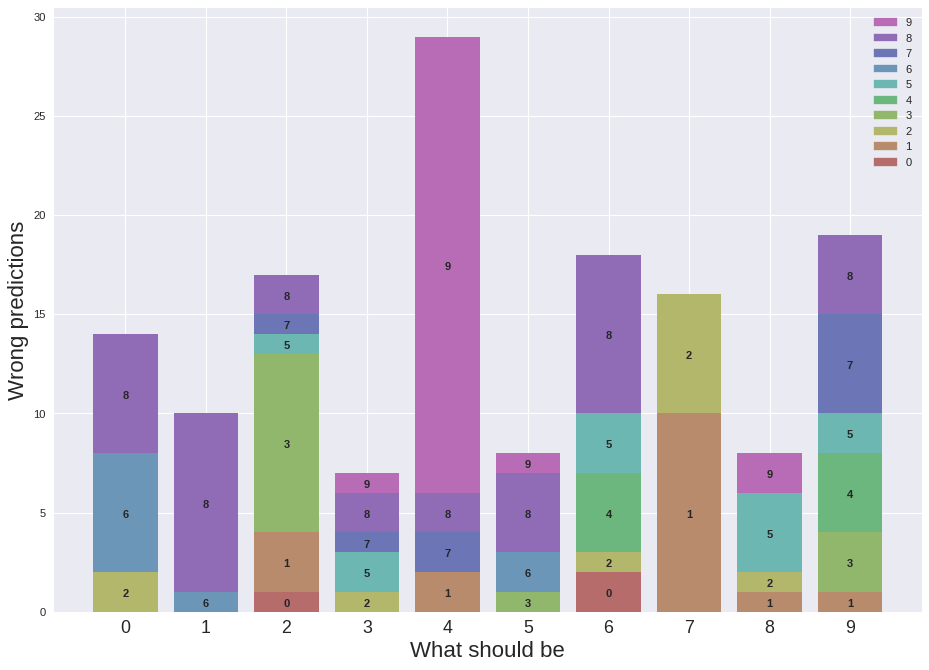

In [179]:
predictions = model.predict(trainX)
decoded = decode_one_hot(predictions)
error_idx = decoded != train['label']
wrong = predictions[error_idx]
true = train['label'][error_idx]
error_plot(decode_one_hot(predictions), train['label'])

In [193]:
def get_errors_by_labels(X, trueY, predictedY, l_true, l_wrong):
    error_idx = (trueY==l_true) & (decode_one_hot(predictedY)==l_wrong)
    return error_idx


def plot_wrong_predictions_by_labels(X, trueY, predictedY, l_true, l_wrong, shape='auto'):
    error_idx = get_errors_by_labels(X, trueY, predictedY, l_true, l_wrong)
    images = X[error_idx].reshape((-1, 28, 28))
    if shape == 'auto':
        rows = max(int(np.sqrt(len(images))), 1)
        cols = rows if rows * rows >= len(images) else rows + 1
        shape = (rows, cols)
        
    plot_images_in_grid(images, *shape)

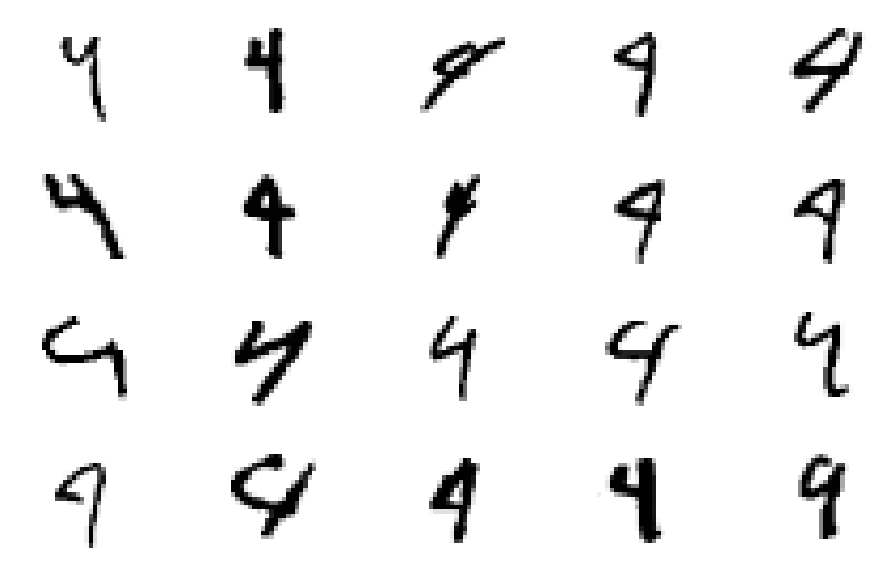

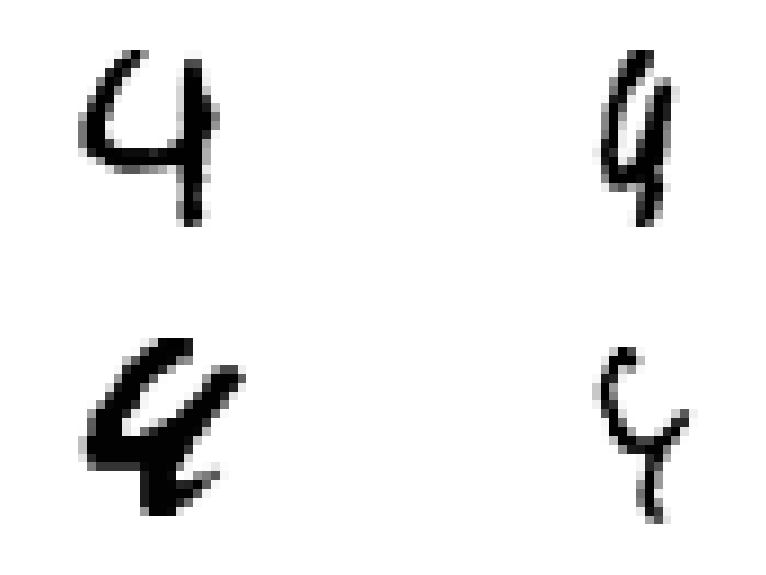

In [216]:
plot_wrong_predictions_by_labels(trainX, train['label'], predictions, l_true=4, l_wrong=9)
plot_wrong_predictions_by_labels(trainX, train['label'], predictions, l_true=9, l_wrong=4)